In [30]:

import sys
sys.path.append('..')
sys.path.append('./src/')
sys.path.append('./util/')
sys.path.append('./data/')

from alignment_vmap import *
import numpy as np
from numpy.fft import fft, ifft

import jax
import time
from jax import vmap, grad, jit, random, lax
from jax import numpy as jnp
from jax.numpy.fft import fft as jfft, ifft as jifft
from util.logger import EventTracker
import matplotlib.pyplot as plt
from alignment_vmap import em_method, fix_point_iter, align_average, autocorr_fft, align_average_and_project, align
from itertools import product

def get_signal(L):
    ## GENERATE SIGNAL
    t = jnp.linspace(0, 2*np.pi, L+1)[:-1]
    x = jnp.sin(t)
    #x = (t < np.pi).astype(float)
    #x = np.random.randn(d)
    return t, x


def get_samples(key, x, noise_std, N):
    L = len(x)
    shiftkey, noisekey = jax.random.split(key, 2)
    shift = jax.random.randint(shiftkey, (N,), 0, L)
    noise = jax.random.normal(noisekey, (N, L)) * noise_std
    y = vmap(lambda s, z: jnp.roll(x + z, s), in_axes=(0, 0))(shift, noise)
    return y, noise, shift

def get_mse(x, y):
    return jnp.mean((x - y) ** 2)

def get_snr(x, noise_std):
    return get_mse(x, jnp.mean(x)) / noise_std ** 2

def get_rel_mse(x, y):
    return get_mse(x, y) / get_mse(x, 0.0)

def get_mean_centered_rel_mse(x, y):
    return get_mse(x, y) / get_mse(x, jnp.mean(x))

def get_aligned_rel_mse(x, y):
    y_al = align(jfft(x), jfft(y), y)
    return get_rel_mse(x, y_al)

SNR: 2.0
MSE: 0.5403460264205933


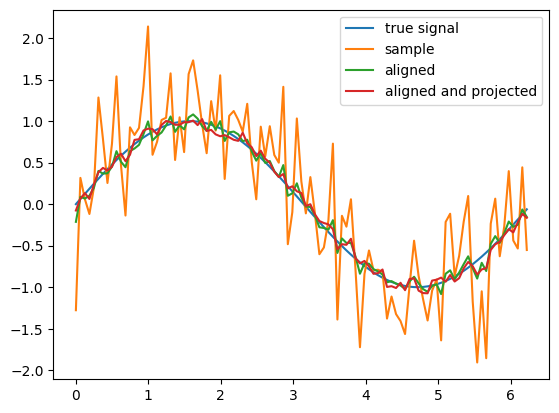

In [31]:
# Main parameters
L = 101
N = 1000 #int(1e4)
noise_std = 0.5 #5 ** 0.5#1.
t, x = get_signal(L)

# Generate signal
y, noise, shift = get_samples(random.PRNGKey(0), x, noise_std, N)

## FOURIER TRANSFORM
xfft = jfft(x)
yfft = jfft(y, axis=1)

# Moments
x_auto_fft = autocorr_fft(xfft) # autocorrelation
y_auto_fft = jnp.clip(jnp.mean(autocorr_fft(yfft), axis=0) - noise_std**2 * L, 0, None) # mean of autocorrelation
y_mean = jnp.mean(yfft[:, 0])  # Mean of means


x_align = jifft(align_average(yfft[0, :], yfft)).real
x_align = align(xfft, fft(x_align), x_align)

x_align_proj = jifft(align_average_and_project(yfft[0, :], yfft, y_auto_fft, y_mean)).real
x_align_proj = align(xfft, fft(x_align_proj), x_align_proj)

x0 = y[0, :]
x0 = align(xfft, fft(x0), x0)

# Plot signal and some samples
print(f'SNR: {get_snr(x, noise_std)}')
print(f'MSE: {get_aligned_rel_mse(x, x0)}')

plt.plot(t, x, label='true signal')
plt.plot(t, x0, label='sample')
plt.plot(t, x_align, label='aligned')
plt.plot(t, x_align_proj, label='aligned and projected')
plt.legend()


In [43]:
def em_run(x0, y, noise_std):
    return em_method(fft(x0), y, noise_std, tol=1e-10, batch_niter=1000, full_niter=500)

def fpi_run(x0, y, noise_std):
    N, L = y.shape
    yfft = jfft(y, axis=1)
    y_auto_fft = jnp.clip(jnp.mean(autocorr_fft(yfft), axis=0) - noise_std**2 * L, 0, None) # mean of autocorrelation
    y_mean = jnp.mean(yfft[:, 0])  # Mean of means

    return  ifft(fix_point_iter(fft(x0), yfft, y_auto_fft, y_mean, alpha=1.0, tol=1e-10, maxiter=3000)).real

def average_std(M):
    def decorator(func):
        def wrapper(*args, **kwargs):
            vals = jnp.array([func(*args, **kwargs) for _ in range(M)])
            return {"mean": jnp.mean(vals, axis=0), "std": jnp.std(vals, axis=0)}
        return wrapper
    return decorator

@average_std(10)
def run_methods(key, x, N, noise_std, methods):
    y, noise, shift = get_samples(key, x, noise_std, N)

    # Add oracle - the other methods do not have access to the noise
    oracle = lambda x0, y, noise_std: x + jnp.mean(noise, axis=0)
    methods = methods + (oracle,)
    
    # Run methods
    def run(method):
        t = time.time()
        val = get_aligned_rel_mse(x, method(y[0, :].copy(), y, noise_std))
        t = time.time() - t
        return val, t
    return jnp.array([run(method) for method in methods])


# Main parameters
L = 41
N = int(1e3)
t, x = get_signal(L)

noise_stds = jnp.logspace(-2, 1., 5)
print(noise_stds)
keys = random.split(random.PRNGKey(0), len(noise_stds))

errs = []
for i, (ns, k) in enumerate(zip(noise_stds, keys)):
    print(f'RUN: std={ns}, total {i+1}/{len(noise_stds)} steps')
    errs.append(run_methods(k, x, N, ns, (em_run, fpi_run)))
    
print(errs)

jnp.save('/home/emastr/github/vahid_project/data/alignment_methods.npy', errs)

[ 0.01        0.05623413  0.31622776  1.7782794  10.        ]
RUN: std=0.009999999776482582, total 1/5 steps
RUN: std=0.05623413249850273, total 2/5 steps
RUN: std=0.3162277638912201, total 3/5 steps


(5, 3, 2)


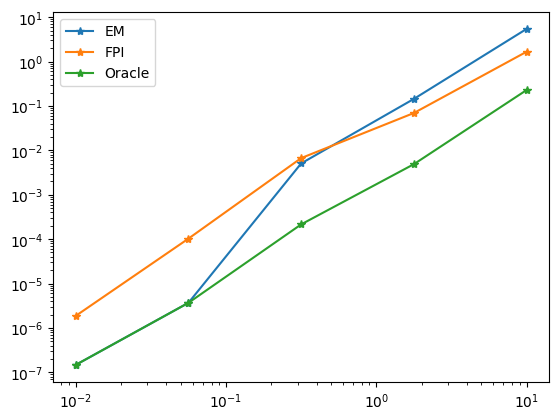

In [ ]:
# DATA: errs = {mean: method x (val, time), std: method x (val, time)}

means = jnp.array([e['mean'] for e in errs])
stds = jnp.array([e['std'] for e in errs])

print(stds.shape)

plt.plot(noise_stds, means[:, 0, 0], '*-', label='EM')
plt.fill_between(noise_stds, means[:, 0, 0] - stds[:, 0, 0], means[:, 0, 0] + stds[:, 0, 0], alpha=0.3)
plt.plot(noise_stds, means[:, 1, 0], '*-', label='FPI')
plt.fill_between(noise_stds, means[:, 1, 0] - stds[:, 1, 0], means[:, 1, 0] + stds[:, 1, 0], alpha=0.3)
plt.plot(noise_stds, means[:, 2, 0], '*-', label='Oracle')
plt.fill_between(noise_stds, means[:, 2, 0] - stds[:, 2, 0], means[:, 2, 0] + stds[:, 2, 0], alpha=0.3)
plt.legend()
plt.xscale('log')
plt.yscale('log')